# Python Operators
This example shows how to run custom Python code using a family of DALI `PythonFunction` Operators to **prototype new augmentations** or **debug the Pipeline**. The idea behind these Operators is to provide a capability to execute Python code operating on DALI tensors' data within the pipeline execution.

Reference: https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/python_operator.html


## Defining  an operation
The first kind of Operator we will try is `PythonFunction`. It wraps a regular Python function and runs it inside a DALI Pipeline. 

Let us define such a function as an example. We will name it `edit_images`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm

from nvidia.dali import ops, types
from nvidia.dali.pipeline import Pipeline

Our function takes two arrays as inputs and returns two outputs. `PythonFunction` uses NumPy arrays as data format for CPU and CuPy arrays for GPU. Note that we do a copy of both images because the input data *should not be modified*.

In [2]:
def edit_images(img1, img2):
    """ 
    Creates a circular mask and uses it to swap those 
    circular parts between the two images
    """
    assert img1.shape == img2.shape
    h, w, c = img1.shape
    y, x = np.ogrid[0:h, 0:w]  # Returns mesh-grid `ndarrays`
    mask = (x - w / 2)**2 + (y - h / 2) ** 2 > h * w / 9
    # swap centers
    res1 = np.copy(img1)
    res1[mask] = img2[mask]
    res2 = np.copy(img2)
    res2[mask] = img1[mask]
    return res1, res2

## Defining a pipeline
To see the Operator in action, we implement a simple data pipeline. We wrap the `edit_images` by passing it as a `function` parameter to `PythonFunction`. See that, in addition to the function, we pass the number of outputs as a parameter.

Having constructed `PythonFunction` as seen below, we can use it in the `define_graph` method like any other Operator!

In [4]:
image_dir = 'data/images'

class CommonPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super().__init__(batch_size, num_threads, device_id, 
                         exec_async=False, exec_pipelined=False, seed=99)
        self.input1 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.input2 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        self.resize = ops.Resize(resize_x=300, resize_y=300)
    
    # NO define_graph ???? maybe because it is abstract parent
    
    def load(self):
        # Since ops.FileReader returns a batch, can you not just call input1 twice?
        jpgs1, labels = self.input1() # first batch
        jpgs2, labels = self.input2() # second batch 
        img1, img2 = self.decode([jpgs1, jpgs2])
        return self.resize([img1, img2])

    
class PythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super().__init__(batch_size, num_threads, device_id, image_dir)
        self.edit_images = ops.PythonFunction(function=edit_images, 
                                              num_outputs=2)
        
    def define_graph(self):
        imgs1, imgs2 = self.load()
        res1, res2 = self.edit_images(imgs1, imgs2)
        return res1, res2    

## Running the pipeline and visualizing the results
Now we can just run the pipeline as usual to see the results.

Note that we need not *necessarily* have two Pipelines, `CommonPipeline` and `PythonFuncPipeline`. We could just make one `MyPipeline` with `load` and `edit_images`, but this perhaps this makes more sense, since `ops.PythonFunction` requires certain flags, and will mostly be used for debugging, so you wouldn't want it in normal pipeline I think.

In [5]:
batch_size = 4

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j)) # <---<< note the `.at(j)`

In [7]:
pipe = PythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
imgs1, imgs2 = pipe.run()

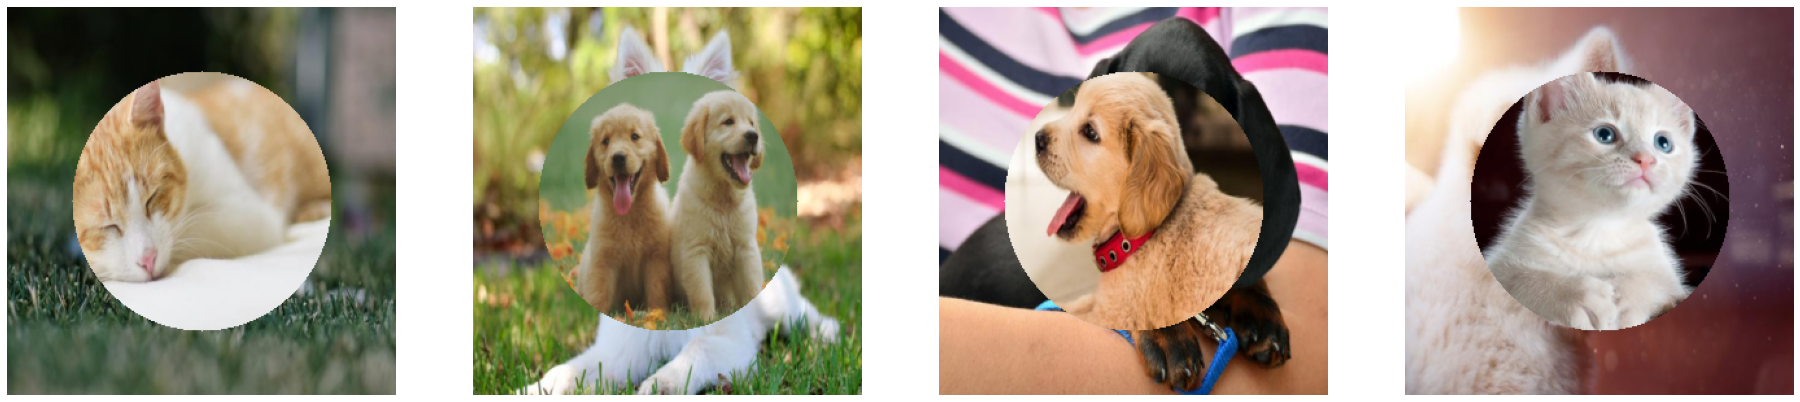

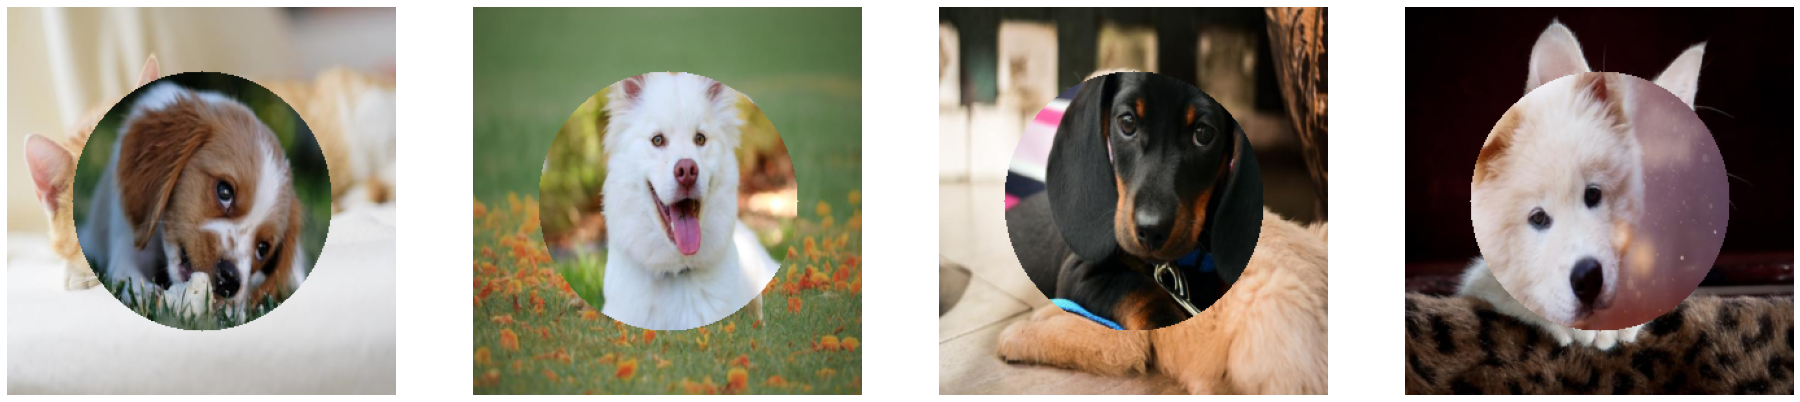

In [8]:
show_images(imgs1)
show_images(imgs2)

# Variety of Python Operators
`PythonFunction` comes in different flavors in DALI.